# Linear regression

[![Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/lento234/ml-tutorials/blob/main/01-basics/01-linear_regression.ipynb)

**References**
- https://pytorch.org/
- https://github.com/yunjey/pytorch-tutorial/blob/master/tutorials/01-basics/linear_regression/main.py
- https://en.wikipedia.org/wiki/Linear_regression
- https://en.wikipedia.org/wiki/Backpropagation
- https://en.wikipedia.org/wiki/Stochastic_gradient_descent

----

**Linear regression**

Given a data set $\{y_i, x_i\}_{i=1}^n$ of $n$ statistical units, we have the following relationship:

$$ y_i = \theta_1 x_i + \theta_0 + \varepsilon_i, \qquad i=1,\ldots, n,$$


where:
- $y_i$ is observed value (dependent variable
- $x_i$ is the independent variable
- $\theta_1$ and $\theta_0$ are model parameters
- $\varepsilon_i$ is the measurement error

**Table of Content**
1. [Setup environment](#setup)
2. [Define the model, loss function and optimizer](#model)
3. [Train the model](#train)
4. [Predict and evaluate the model](#evaluate)
5. [Save the trained model](#save)
6. [Load pretrained model](#load)

[^1]: https://github.com/pytorch/pytorch

<a id="setup"></a>
## 1. Setup environment

### Load packages / modules

In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim

In [2]:
mpl.style.use('seaborn-poster')
mpl.rcParams['mathtext.fontset'] = 'cm'
mpl.rcParams['figure.figsize'] = 5 * np.array([1.618033988749895, 1])

In [3]:
# Reproducibility
seed = 234
np.random.seed(seed)
torch.random.manual_seed(seed);

### Generate training dataset

In [4]:
n = 500
theta_1 = 2.0
theta_0 = 0.4
eps_std = 0.2

In [5]:
x_train = np.random.rand(n,1)-0.5
eps = np.random.normal(scale=eps_std, size=(n,1))
y_train = x_train*theta_1 + theta_0 + eps

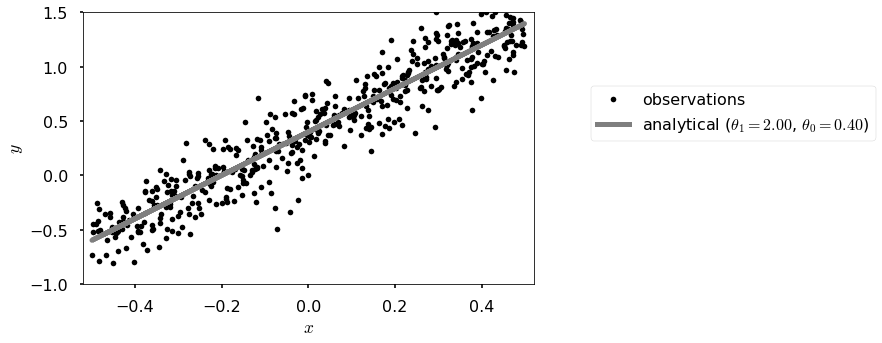

In [6]:
fig, ax = plt.subplots()
ax.plot(x_train, y_train, 'k.', label='observations')
ax.plot(x_train, x_train*theta_1 + theta_0, 'tab:gray', lw=5,
        label=r'analytical ($\theta_1={:.2f}$, $\theta_0={:.2f}$)'.format(theta_1, theta_0))
ax.set(xlabel='$x$', ylabel='$y$', xlim=(-0.52,0.52), ylim=(-1.0, 1.5));
# ax.legend();
fig.legend(loc='right', bbox_to_anchor=(1.5, 0.6));

<a id="model"></a>
## 2. Define the model, loss function and optimizer

### Hyperparameters

In [7]:
n_features = 1 # number of nodes (1 weight + 1 bias)
num_epochs = 150 # i.e. number of iterations
learning_rate = 0.2

### Model

$$ \mathcal{F}(x;\ \theta): x \rightarrow y $$

**Linear 1-D model**:

$$ \mathcal{F}(x;\ \theta) = w x + b = \hat{y}$$

where:
- $y$ is the ground truth
- $\hat{y}$ is the predicted output
- $\theta$ are the trainable parameters, with
    - $w$ is the learnable **weight**, i.e. $w \equiv \theta_1$
    - $b$ is the learnable **bias**, i.e. $b \equiv \theta_0$

In [8]:
# Linear regression model
model = nn.Linear(in_features=n_features, out_features=n_features)
model

Linear(in_features=1, out_features=1, bias=True)

In [9]:
for i, (name, param) in enumerate(model.named_parameters()):
    print(r"{:6s} (theta_{}): {:.4f}".format(name, 1-i, param.item()))

weight (theta_1): 0.8553
bias   (theta_0): 0.1633


### Loss function

**$L^1$-norm:**

$$ \mathcal{L}(\hat{Y}, Y;\ \theta) = \textrm{mean} \left( \{l_1,\dots,l_N\}^\top \right), \quad l_n = \left| \hat{y}_n - y_n \right| $$
where:
- $X \in \mathbb{R}^N$ is the input matrix
- $Y \in \mathbb{R}^N$ is the ground truth matrix
- $N$ is the batch size (for now, batch size = number of examples)

In [10]:
# Loss and optimizer
criterion = nn.L1Loss() # L^1-norm, aka. mean absolute error loss
criterion

L1Loss()

### Optimizer

**Stochastic gradient descent**

$$ \theta^{n+1} = \theta^n - \eta \nabla \mathcal{L}(\theta^n) $$

where:
- $\eta$ is the learning rate (i.e. step size)

In [11]:
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate) # Stochastic gradient-descent
optimizer

SGD (
Parameter Group 0
    dampening: 0
    lr: 0.2
    momentum: 0
    nesterov: False
    weight_decay: 0
)

<a id="train"></a>
## 3. Train the model

$$ \mathcal{F}^* = \arg \min_{\mathcal{F}}\ \mathcal{L}(\hat{Y}, Y;\ \theta)$$

**Algorithm:**
1. Convert data to torch tensor: `torch.from_numpy(...)`
2. Forward pass: `y_hat = model(x)`
3. Calculate loss: `loss = criterion(y_hat, y)`
4. Compute gradients: `loss.backward()`
5. Update weights: `optimizer.step()`

In [12]:
history = dict(loss=[], parameters=[], grads=[])
for epoch in range(num_epochs):
    # 1. Convert numpy arrays to torch tensors
    x = torch.from_numpy(x_train.astype('float32'))
    y = torch.from_numpy(y_train.astype('float32'))

    # 2. Forward-pass:
    y_hat = model(x) # prediction step
    
    # 3. Calculate loss
    loss = criterion(y_hat, y)
    
    # 4. Backward propagation 
    optimizer.zero_grad() # reset gradients to zero
    loss.backward() # backprop: calculate gradients w.r.t to loss
    
    # 5. Update weights
    optimizer.step() # update gradient
    
    # 6. Log
    history['loss'].append(loss.item())
    history['parameters'].append([param.detach().item() for param in model.parameters()])
    history['grads'].append([param.grad.detach().item() for param in model.parameters()])
    if (epoch % 10) == 0 or epoch==(num_epochs-1):
        print('[Epoch {:3d}]: loss={:.4f}, w={:.2f}, b={:.2f}'.format(
            epoch, history['loss'][-1], *history['parameters'][-1]))

[Epoch   0]: loss=0.3869, w=0.89, b=0.26
[Epoch  10]: loss=0.2384, w=1.31, b=0.42
[Epoch  20]: loss=0.1822, w=1.63, b=0.40
[Epoch  30]: loss=0.1639, w=1.81, b=0.40
[Epoch  40]: loss=0.1591, w=1.90, b=0.40
[Epoch  50]: loss=0.1579, w=1.94, b=0.40
[Epoch  60]: loss=0.1575, w=1.97, b=0.40
[Epoch  70]: loss=0.1573, w=1.99, b=0.40
[Epoch  80]: loss=0.1572, w=2.00, b=0.40
[Epoch  90]: loss=0.1572, w=2.01, b=0.40
[Epoch 100]: loss=0.1571, w=2.02, b=0.40
[Epoch 110]: loss=0.1571, w=2.03, b=0.40
[Epoch 120]: loss=0.1571, w=2.03, b=0.40
[Epoch 130]: loss=0.1571, w=2.04, b=0.40
[Epoch 140]: loss=0.1571, w=2.04, b=0.40
[Epoch 149]: loss=0.1571, w=2.04, b=0.40


### Training loss history

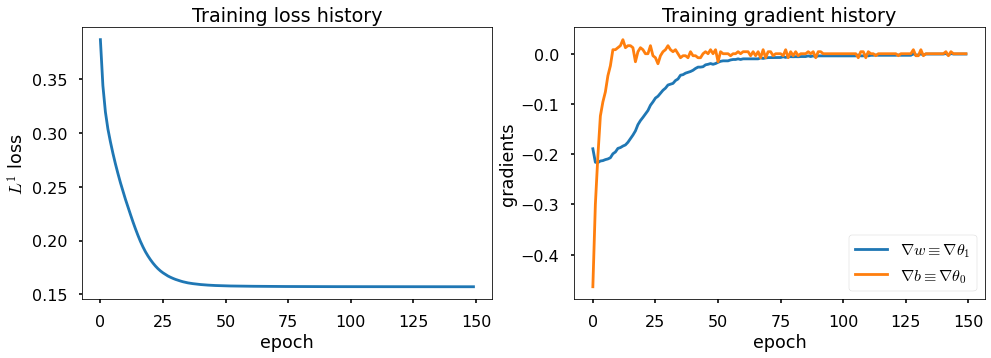

In [13]:
fig, axes = plt.subplots(1, 2, figsize=(mpl.rcParams['figure.figsize'][0]*2, mpl.rcParams['figure.figsize'][1]))

axes[0].plot(history['loss'])
axes[0].set(xlabel='epoch', ylabel='$L^1$ loss',
       title='Training loss history');

axes[1].plot(history['grads'])
axes[1].set(xlabel='epoch', ylabel='gradients',
            title='Training gradient history');
axes[1].legend([r'$\nabla w \equiv \nabla \theta_1$',
                r'$\nabla b \equiv \nabla \theta_0$'])

### Optimization over the loss landscape

In [14]:
# L^1 norm: numpy version
l1_norm = lambda y_hat, y: np.abs(y_hat - y).mean(axis=0)

# Loss landscape
theta_1_h, theta_0_h = np.meshgrid(np.linspace(0, 4),
                                 np.linspace(-0.2, 0.8))
loss_surface = l1_norm(x_train[...,None]*theta_1_h[None] + theta_0_h[None],
                       y_train[...,None])

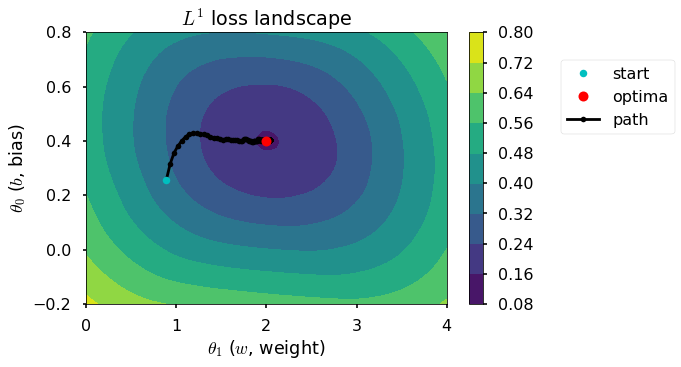

In [15]:
fig, ax = plt.subplots()
im = ax.contourf(theta_1_h, theta_0_h, loss_surface)
ax.plot(*history['parameters'][0], 'c.', ms=15, label='start', zorder=10)
ax.plot(theta_1, theta_0, 'r.', ms=20, label='optima', zorder=10)
ax.plot(np.array(history['parameters'])[:,0],
        np.array(history['parameters'])[:,1],
        '.-', c='k', label='path')
ax.set(xlabel=r'$\theta_1$ ($w$, weight)',
       ylabel=r'$\theta_0$ ($b$, bias)',
       title='$L^1$ loss landscape')
fig.colorbar(im, ax=ax)
fig.legend(loc='right', bbox_to_anchor=(1.15, 0.7));

<a id="evaluate"></a>
## 4. Predict and evaluate the model

### Training accuracy

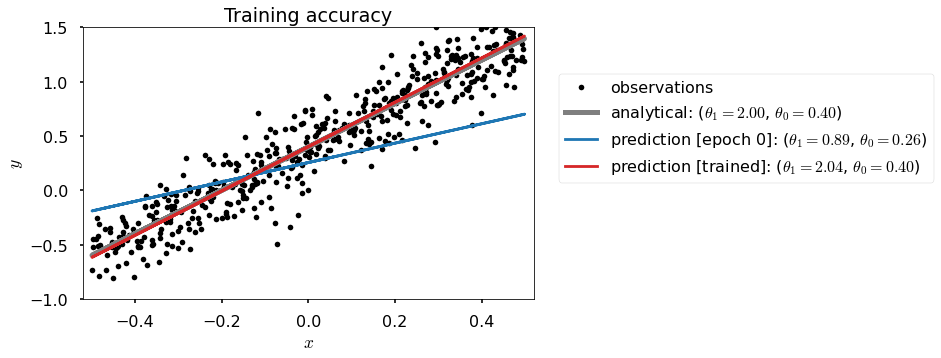

In [16]:
# Predict
predict = model(torch.from_numpy(x_train.astype('float32'))).detach().numpy()

# Plot the graph
fig, ax = plt.subplots()
ax.plot(x_train, y_train, 'k.', label='observations')
ax.plot(x_train, x_train*theta_1 + theta_0, 'tab:gray', lw=5,
        label=r'analytical: ($\theta_1={:.2f}$, $\theta_0={:.2f}$)'.format(theta_1, theta_0))
ax.plot(x_train, x_train*history['parameters'][0][0] + history['parameters'][0][1], 'tab:blue',
        label=r'prediction [epoch 0]: ($\theta_1={:.2f}$, $\theta_0={:.2f}$)'.format(*history['parameters'][0]))
ax.plot(x_train, predict, 'tab:red',
        label=r'prediction [trained]: ($\theta_1={:.2f}$, $\theta_0={:.2f}$)'.format(*history['parameters'][-1]))
ax.set(xlabel='$x$', ylabel='$y$',
       title='Training accuracy',
       xlim=(-0.52,0.52), ylim=(-1.0, 1.5))

fig.legend(loc='right', bbox_to_anchor=(1.6, 0.6));

<a id="save"></a>
## 5. Save the trained model

In [17]:
# Save the model checkpoint
torch.save(model.state_dict(), 'model.ckpt')

<a id="load"></a>
## 6. Load pretrained model

In [18]:
checkpoint = torch.load('model.ckpt')
checkpoint

OrderedDict([('weight', tensor([[2.0430]])), ('bias', tensor([0.4025]))])

In [19]:
model.load_state_dict(checkpoint)

<All keys matched successfully>